# Analisi Dati PII RTP

Lo script è realizzato per anonimizzare un qualsiasi dataset fornito in input mediante accesso al DataLake.
Nella fattispecie si utilizza il database pagoPA

## Caricamento librerie ed import recognizers

In [1]:
from presidio_analyzer import AnalyzerEngine
from presidio_anonymizer import AnonymizerEngine
from presidio_analyzer.nlp_engine import NlpEngineProvider
from presidio_analyzer import PatternRecognizer, Pattern

In [2]:
import cml.data_v1 as cmldata

## Connessione DataLake & recupero dati

In [3]:
CONNECTION_NAME = "dl-analysis-impala-vw"
conn = cmldata.get_connection(CONNECTION_NAME)

## Sample Usage to get pandas data frame
QUERY = """
select po.after.description
from pagopa.silver_gpd_payment_position pp
INNER JOIN pagopa.silver_gpd_payment_option po ON pp.after.id = po.after.payment_position_id
INNER JOIN pagopa.silver_gpd_transfer t ON t.after.payment_option_id = po.after.id
WHERE 
-- Regione Veneto Bollo Auto
pp.after.status IN ("PAID","REPORTED")
AND t.after.category IN ("0301105TS")
AND pp.after.organization_fiscal_code = "80007580279"

-- Regione Veneto TARI
-- pp.after.status in ('PAID','REPORTED')
-- and t.after.category in ('0201102IM', '0201133IM', '0101109IM','0101101IM')
-- and pp.after.organization_fiscal_code not in ('00145130597','00327470795','80002670604','81003590593')
-- LIMIT 5
"""

dataframe = conn.get_pandas_dataframe(QUERY)
# print(dataframe)
# Closing the connection
conn.close()


## Configurazione della lingua

In [4]:
# NLP engine configuration (Spacy)
nlp_config = {
    "nlp_engine_name": "spacy",
    "models": [{"lang_code": "it", "model_name": "it_core_news_lg"}],
}
provider = NlpEngineProvider(nlp_configuration=nlp_config)
nlp_engine_with_italian = provider.create_engine()


## Definizione del custom patter per le targhe

In [5]:
# Custom recognizer for Italian vehicle plates
#plate_pattern = Pattern(name="IT_VEHICLE_PLATE", regex=r"[A-Z]{2}\d{3}[A-Z]{2}|[A-Z]{2}\d{4}[A-Z]{2}|\d{2}[A-Z]{3}\d{2}", score=0.8)
plate_pattern = Pattern(name="IT_VEHICLE_PLATE", regex=r"\b([A-Z]{2}\d{3}[A-Z]{2}|\d{2}[A-Z]{2}\d{2}|[A-Z]{2}\d{5}|\d{2}[A-Z]{3}\d{2})\b", score=0.8)

plate_recognizer = PatternRecognizer(patterns=[plate_pattern], supported_entity="IT_VEHICLE_PLATE", name="IT_VEHICLE_PLATE", supported_language="it")


## Inizializzazione di Presidio 

In [6]:
# Initialize Presidio with the custom recognizer
analyzer = AnalyzerEngine(
    supported_languages=["en", "it"],
    nlp_engine=nlp_engine_with_italian,
)
analyzer.registry.add_recognizer(plate_recognizer)

anonymizer = AnonymizerEngine()

# Entities to detect (including IT_VEHICLE_PLATE)
entities = [
    "IT_VEHICLE_PLATE",  # Include Italian vehicle plates
    "IT_FISCAL_CODE",
    "IT_DRIVER_LICENSE", 
    "IT_VAT_CODE",       
    "IT_PASSPORT",       
    "IT_IDENTITY_CARD",  
    "CREDIT_CARD",       
    "DATE_TIME",         
    "EMAIL_ADDRESS",     
    "IBAN_CODE",         
    "PERSON",            
    "PHONE_NUMBER",      
]

## Analyzer & Anonymizer

In [7]:
# Funzione per anonimizzare il testo
import pandas as pd
from concurrent.futures import ProcessPoolExecutor
from tqdm import tqdm

# Funzione per anonimizzare il testo
def anonymize_text(text):
    if not text:
        return text
    results = analyzer.analyze(text=text, entities=entities, language="it")
    return anonymizer.anonymize(text=text, analyzer_results=results).text

# Funzione wrapper per multiprocessing
def anonymize_wrapper(args):
    text, index, total = args
    if index % 50000 == 0 or index == total - 1:
        print(f"Elaborazione progresso: {index+1}/{total} righe completate.")
    return anonymize_text(text)

print("Inizio anonimizzazione con multiprocessing...")

# Configurazione tqdm
tqdm.pandas()

# Parallelizzazione con ProcessPoolExecutor
with ProcessPoolExecutor() as executor:
    dataframe["description_anon"] = list(
        tqdm(executor.map(anonymize_wrapper, zip(dataframe["after.description"], range(len(dataframe)), [len(dataframe)] * len(dataframe))), 
             total=len(dataframe))
    )

print("Anonimizzazione completata.")

# Salvataggio finale
dataframe.to_csv("anonimizzati.csv", index=False)
print("CSV generato con successo: anonimizzati.csv")


Inizio anonimizzazione con multiprocessing...
Elaborazione progresso: 1/1229953 righe completate.


  4%|▍         | 49959/1229953 [01:09<26:30, 741.72it/s]

Elaborazione progresso: 50001/1229953 righe completate.


  8%|▊         | 99988/1229953 [02:20<28:10, 668.39it/s]

Elaborazione progresso: 100001/1229953 righe completate.


 12%|█▏        | 149941/1229953 [03:30<26:36, 676.37it/s]

Elaborazione progresso: 150001/1229953 righe completate.


 16%|█▋        | 199971/1229953 [04:41<23:41, 724.61it/s]

Elaborazione progresso: 200001/1229953 righe completate.


 20%|██        | 249976/1229953 [05:53<22:00, 742.22it/s]

Elaborazione progresso: 250001/1229953 righe completate.


 24%|██▍       | 299945/1229953 [07:03<21:12, 730.59it/s]

Elaborazione progresso: 300001/1229953 righe completate.


 28%|██▊       | 349951/1229953 [08:13<22:34, 649.62it/s]

Elaborazione progresso: 350001/1229953 righe completate.


 33%|███▎      | 399938/1229953 [09:24<19:59, 692.16it/s]

Elaborazione progresso: 400001/1229953 righe completate.


 37%|███▋      | 449920/1229953 [10:34<17:40, 735.21it/s]

Elaborazione progresso: 450001/1229953 righe completate.

 37%|███▋      | 449996/1229953 [10:35<17:31, 741.45it/s]

 41%|████      | 499972/1229953 [11:46<16:21, 743.50it/s]

Elaborazione progresso: 500001/1229953 righe completate.


 45%|████▍     | 549938/1229953 [12:57<15:55, 711.43it/s]

Elaborazione progresso: 550001/1229953 righe completate.


 53%|█████▎    | 649946/1229953 [15:17<13:22, 722.70it/s]

Elaborazione progresso: 650001/1229953 righe completate.


 57%|█████▋    | 699909/1229953 [16:27<10:50, 815.32it/s]

Elaborazione progresso: 700001/1229953 righe completate.


 61%|██████    | 749985/1229953 [17:38<11:38, 687.24it/s]

Elaborazione progresso: 750001/1229953 righe completate.


 65%|██████▌   | 799954/1229953 [18:48<09:21, 766.18it/s]

Elaborazione progresso: 800001/1229953 righe completate.


 69%|██████▉   | 849950/1229953 [19:59<09:03, 699.55it/s]

Elaborazione progresso: 850001/1229953 righe completate.


 73%|███████▎  | 899959/1229953 [21:08<07:35, 724.02it/s]

Elaborazione progresso: 900001/1229953 righe completate.


 77%|███████▋  | 949959/1229953 [22:17<06:16, 743.20it/s]

Elaborazione progresso: 950001/1229953 righe completate.


 81%|████████▏ | 999943/1229953 [23:27<05:25, 707.51it/s]

Elaborazione progresso: 1000001/1229953 righe completate.


 85%|████████▌ | 1049932/1229953 [24:37<04:01, 746.43it/s]

Elaborazione progresso: 1050001/1229953 righe completate.


 89%|████████▉ | 1099972/1229953 [25:47<03:12, 676.02it/s]

Elaborazione progresso: 1100001/1229953 righe completate.


 98%|█████████▊| 1199993/1229953 [28:09<00:39, 755.84it/s]

Elaborazione progresso: 1200001/1229953 righe completate.


100%|█████████▉| 1229911/1229953 [28:52<00:00, 682.92it/s]

Elaborazione progresso: 1229953/1229953 righe completate.


100%|██████████| 1229953/1229953 [28:52<00:00, 709.96it/s]


Anonimizzazione completata.
CSV generato con successo: anonimizzati.csv


## Elaboro file csv e calcolo risultati di analisi

Righe totali: 1229953
IT_VEHICLE_PLATE -> 1079196
IT_FISCAL_CODE -> 781119
DATE_TIME -> 559714
PERSON -> 280587
PHONE_NUMBER -> 959364
IT_VAT_CODE -> 145906
IT_IDENTITY_CARD -> 20
CREDIT_CARD -> 1

Combinazioni di entità trovate:
SOLO IT_VEHICLE_PLATE -> 235252
DATE_TIME-IT_FISCAL_CODE-IT_VEHICLE_PLATE-PERSON-PHONE_NUMBER -> 104331
IT_FISCAL_CODE-IT_VEHICLE_PLATE-PHONE_NUMBER -> 211020
DATE_TIME-IT_FISCAL_CODE-IT_VEHICLE_PLATE-PHONE_NUMBER -> 307236
DATE_TIME-IT_FISCAL_CODE-PERSON-PHONE_NUMBER -> 44431
DATE_TIME-IT_FISCAL_CODE-PHONE_NUMBER -> 46376
DATE_TIME-IT_VAT_CODE-IT_VEHICLE_PLATE-PERSON-PHONE_NUMBER -> 7408
DATE_TIME-IT_VAT_CODE-IT_VEHICLE_PLATE-PHONE_NUMBER -> 22152
DATE_TIME-IT_VEHICLE_PLATE-PERSON-PHONE_NUMBER -> 18951
IT_FISCAL_CODE-IT_VEHICLE_PLATE-PERSON-PHONE_NUMBER -> 54086
DATE_TIME-IT_VAT_CODE-PHONE_NUMBER -> 1545
SOLO PERSON -> 6761
IT_VAT_CODE-IT_VEHICLE_PLATE-PHONE_NUMBER -> 93943
DATE_TIME-PERSON-PHONE_NUMBER -> 3222
IT_VAT_CODE-IT_VEHICLE_PLATE-PERSON-PHONE_NUMBER

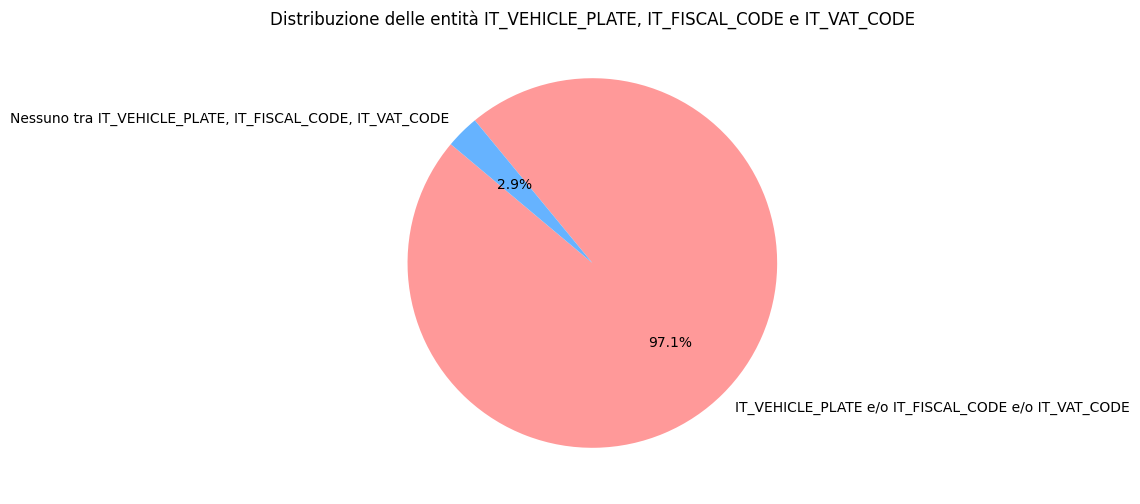

In [8]:
import csv
from collections import Counter
import matplotlib.pyplot as plt

# Definizione delle entità da cercare
ENTITIES = [
    "IT_FISCAL_CODE",
    "IT_DRIVER_LICENSE",
    "IT_VAT_CODE",
    "IT_PASSPORT",
    "IT_IDENTITY_CARD",
    "CREDIT_CARD",
    "DATE_TIME",
    "EMAIL_ADDRESS",
    "IBAN_CODE",
    "PERSON",
    "PHONE_NUMBER",
    "IT_VEHICLE_PLATE"
]

def analyze_csv(file_path):
    total_rows = 0
    entity_counts = Counter()
    combination_counts = Counter()
    
    targ_cf_vat_count = 0
    neither_targ_cf_vat_count = 0
    
    with open(file_path, newline='', encoding='utf-8') as csvfile:
        reader = csv.DictReader(csvfile)
        
        for row in reader:
            total_rows += 1
            description_anon = row['description_anon']
            found_entities = [entity for entity in ENTITIES if f'<{entity}>' in description_anon]
            
            for entity in found_entities:
                entity_counts[entity] += 1
            
            if len(found_entities) == 1:
                combination_counts[f'SOLO {found_entities[0]}'] += 1
            elif found_entities:
                combination_counts['-'.join(sorted(found_entities))] += 1
            
            # Contatori specifici
            has_targa = "IT_VEHICLE_PLATE" in found_entities
            has_cf = "IT_FISCAL_CODE" in found_entities
            has_vat = "IT_VAT_CODE" in found_entities
            
            if has_targa or has_cf or has_vat:
                targ_cf_vat_count += 1
            else:
                neither_targ_cf_vat_count += 1
    
    # Output dei risultati
    print(f"Righe totali: {total_rows}")
    
    for entity, count in entity_counts.items():
        print(f"{entity} -> {count}")
    
    print("\nCombinazioni di entità trovate:")
    for combination, count in combination_counts.items():
        print(f"{combination} -> {count}")
    
    print("\nStatistiche specifiche:")
    print(f"IT_VEHICLE_PLATE e/o IT_FISCAL_CODE e/o IT_VAT_CODE -> {targ_cf_vat_count} ({(targ_cf_vat_count / total_rows) * 100:.2f}%)")
    print(f"Nessuno tra IT_VEHICLE_PLATE, IT_FISCAL_CODE, IT_VAT_CODE -> {neither_targ_cf_vat_count} ({(neither_targ_cf_vat_count / total_rows) * 100:.2f}%)")
    
    # Creazione grafico a torta
    labels = [
        "IT_VEHICLE_PLATE e/o IT_FISCAL_CODE e/o IT_VAT_CODE",
        "Nessuno tra IT_VEHICLE_PLATE, IT_FISCAL_CODE, IT_VAT_CODE"
    ]
    sizes = [targ_cf_vat_count, neither_targ_cf_vat_count]
    colors = ["#ff9999", "#66b3ff"]
    
    plt.figure(figsize=(8, 6))
    plt.pie(sizes, labels=labels, autopct="%.1f%%", colors=colors, startangle=140)
    plt.title("Distribuzione delle entità IT_VEHICLE_PLATE, IT_FISCAL_CODE e IT_VAT_CODE")
    plt.show()

# Esegui la funzione sul file CSV
analyze_csv("anonimizzati.csv")